In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import scipy.optimize as opt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv('data/FRM_SPX_Time_Series_FRM_19862020.csv',
                 delim_whitespace = True, names = ['Lambda'], parse_dates=True)
df['Date'] = df.index

In [3]:
df1987 = df['1987-08-01':'1988-06-01']
numberdays = len(df1987)
Days = pd.Series(range(0, numberdays, 1), index = df1987.index)
df1987['Day'] = Days

df2007 = df['2007-01-01':'2010-12-12']
numberdays = len(df2007)
Days = pd.Series(range(0, numberdays, 1), index = df2007.index)
df2007['Day'] = Days


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Formulas for the logistic function of the growth rate and for the asymetrical Hubbert curves from: file:///Users/lucasumann/Downloads/1-s2.0-S0920410517307209-main.pdf

In [4]:
def logistic_function(t, N_0, K, r):
    N_t = N_0*np.exp(r*t)/(1+(N_0/K)*(np.exp(r*t)-1))
    return N_t

def logistic_function_growth_rate(t, r_max, r_min, t_peak, k):
    r_t = r_max - ((r_max - r_min)/(1 + np.exp(k*(t - t_peak))))
    return r_t

def hubbert_curve(t, N_0, K, r):
    nominator = np.exp(r*t)*N_0*(K-N_0)
    denominator = K*((1+(N_0/K)*(np.exp(r*t)-1))**2)
    return nominator/denominator

def hubbert_curve_asy(t, K, r_max, r_min, t_peak, k):
    nominator = logistic_function_growth_rate(t, r_max, r_min, t_peak, k) * K * np.exp(-logistic_function_growth_rate(t, r_max, r_min, t_peak,k)*(t-t_peak))
    denominator = (1 + np.exp(-logistic_function_growth_rate(t, r_max, r_min, t_peak, k)*(t-t_peak)))**2
    return nominator/denominator

def two_hubbert_curve(t, N_0_1, K_1, r_1, N_0_2, K_2, r_2):
    return hubbert_curve(t, N_0=N_0_1, K=K_1, r=r_1) + hubbert_curve(t, N_0=N_0_2, K=K_2,r=r_2)

def wkh_function(t, alpha1, beta1, alpha2, beta2):
    y = np.exp(-(t-alpha1)/beta1) / (beta1*(1 + np.exp(-(t-alpha1)/beta1))**2 ) + np.exp(-(t-alpha2)/beta2) / (beta2*(1 + np.exp(-(t-alpha2)/beta2))**2 )
    return y

In [5]:
y0 = df1987.Lambda.iloc[0]
y = df1987.Lambda - y0
x = np.arange(len(y))+1

(N_0, K, r), cov = opt.curve_fit(hubbert_curve, x[1:], y[1:], p0 = (0, 0.1, 0.1), bounds = ([-1,0,0], [100,100,100]))

df1987['Fitted'] = pd.Series(hubbert_curve(t = x, N_0 = N_0, K = K, r =r)+y0, index = df1987.index)


df1987_long = pd.melt(df1987, id_vars=['Date'], value_vars=['Lambda', 'Fitted'])
# fig = px.line(data_frame = df1987_long,
#               x = 'Date', y = "value", color = "variable",
#               template = "ggplot2",
#               title = "1987 crisis, from 1987-08-01 to 1988-06-01", labels = {"Lambda":"FRM Lambda"})
# fig.show()
# plt.figure(figsize=(16,9))
# plt.title("1987 crisis, from 1987-08-01 to 1988-06-01")
# plt.plot(x,y, label = 'FRM Lambda')
# plt.plot(hubbert_curve(t = x, N_0 = N_0, K = K, r =r), label = 'Fitted Hubbert Curve')
# plt.legend()


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



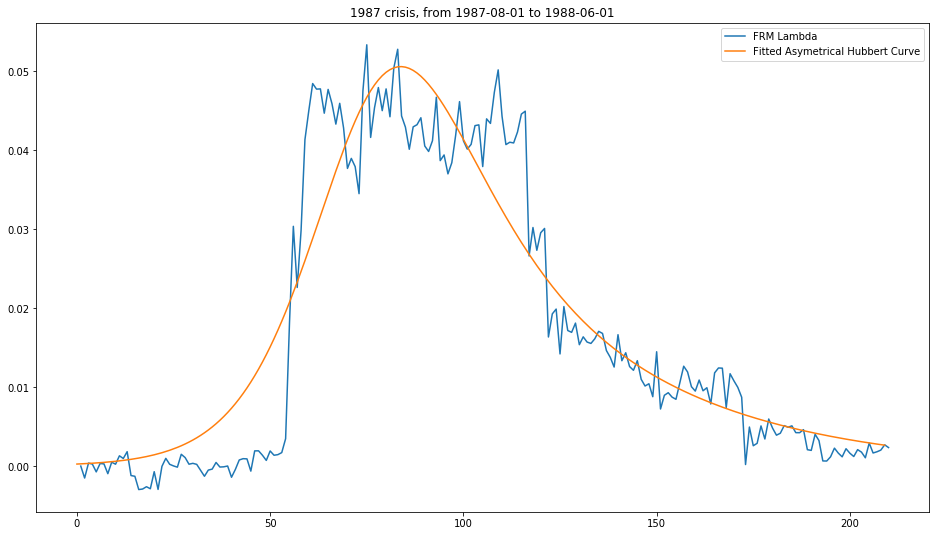

In [6]:
y0 = df1987.Lambda.iloc[0]
y = df1987.Lambda - y0
x = np.arange(len(y))+1
(K, r_max, r_min, t_peak, k), cov = opt.curve_fit(hubbert_curve_asy, x[1:], y[1:], p0 = (0.1, 0.1, 0, 100, 1),
                                 bounds = ([0, 0, -0.1, 0, 0], [100, 100, 10, len(x), 100]))

df1987['Fitted'] = pd.Series(hubbert_curve_asy(t = x, K = K, r_max = r_max, r_min = r_min, t_peak = t_peak, k = k)+y0, index = df1987.index)


df1987_long = pd.melt(df1987, id_vars=['Date'], value_vars=['Lambda', 'Fitted'])
fig = px.line(data_frame = df1987_long,
              x = 'Date', y = "value", color = "variable",
              template = "ggplot2",
              title = "1987 crisis, from 1987-08-01 to 1988-06-01", labels = {"Lambda":"FRM Lambda"})
fig.show()


plt.figure(figsize=(16,9))
plt.title("1987 crisis, from 1987-08-01 to 1988-06-01")
plt.plot(x,y, label = 'FRM Lambda')
plt.plot(hubbert_curve_asy(t = x, K = K, r_max = r_max, r_min = r_min, t_peak = t_peak, k = k), label = 'Fitted Asymetrical Hubbert Curve')
plt.legend()

In [ ]:
# import plotly.express as px

fig = go.Figure(data=[
    go.Scatter(df1987_long)])


In [ ]:
y = df1987.Lambda - df1987.Lambda.iloc[0]
x = np.arange(len(y))+1
(alpha1, beta1, alpha2, beta2), cov = opt.curve_fit(wkh_function, x[1:], y[1:], p0 = (90, 30, 110, 30),
                                 bounds = ([0, 0, 0, 0], [len(x), 100, len(x), 100]))

plt.figure(figsize=(16,9))
plt.title("1987 crisis")
plt.plot(x,y, label = 'FRM Lambda')
plt.plot(wkh_function(t = x, alpha1 = alpha1, beta1 = beta1, alpha2 = alpha2, beta2 = beta2), label = 'Fitted Function from WKH')
plt.legend()

In [ ]:
y = df2007.Lambda - df2007.Lambda.iloc[0]
x = np.arange(len(y))+1
(K, r_max, r_min, t_peak, k), cov = opt.curve_fit(hubbert_curve_asy, x[1:], y[1:], p0 = (30, 0.5, 0, len(x)/2, 1),
                                 bounds = ([0, 0, -0.1, 0, 0], [100, 100, 10, len(x), 100]))

plt.figure(figsize=(16,9))
plt.title("2007 crisis")
plt.plot(x,y, label = 'FRM Lambda')
plt.plot(hubbert_curve_asy(t = x, K = K, r_max = r_max, r_min = r_min, t_peak = t_peak, k = k), label = 'Fitted Asymetrical Hubbert Curve')
plt.legend()

In [ ]:
y = df2007.Lambda - df2007.Lambda.iloc[0]
x = np.arange(len(y))+1
(N_0, K, r), cov = opt.curve_fit(logistic_function, x[1:], y[1:].cumsum(), p0 = (0,10, 0.1), bounds = ([-1,0,0], [100,100,100]))


plt.figure(figsize=(16,9))
plt.title("2007 crisis")
plt.plot(x, y.cumsum(), label = 'FRM Lambda')
#plt.plot(hubbert_curve(t = x, N_0 = N_0, K = K, r =r), label = 'Fitted Hubbert Curve')
plt.legend()